# GEE_ARROZ

# CARGA DE DATOS

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cargar el dataset (Asegúrate de que el nombre coincida con tu descarga)
df = pd.read_csv('Dataset_Arroz_Vietnam_BigData_2017_2025.csv')

# 2. Convertir la fecha al formato correcto de Python
df['fecha'] = pd.to_datetime(df['fecha'])

# 3. Limpiar valores nulos (Indispensable después de GEE)
# Eliminamos filas donde el satélite no pudo ver nada por nubes
df = df.dropna(subset=['NDVI', 'NDWI', 'EVI'])

# 4. Feature Engineering: Crear el "Mes" como variable categórica
df['mes'] = df['fecha'].dt.month

print(f"Dataset cargado con {len(df)} filas después de limpieza.")
print(df.head())

Dataset cargado con 5906 filas después de limpieza.
       fecha      NDVI      NDWI       EVI  mean  mes
0 2019-01-06  0.459762 -0.369665  1.128866   NaN    1
1 2019-01-06  0.503466 -0.482422  1.279362   NaN    1
2 2019-01-06  0.321404 -0.237113  0.852812   NaN    1
3 2019-01-06  0.762872 -0.681891  2.104253   NaN    1
4 2019-01-06  0.160692 -0.212395  0.296263   NaN    1


# SEÑALES FENOLOGICAS

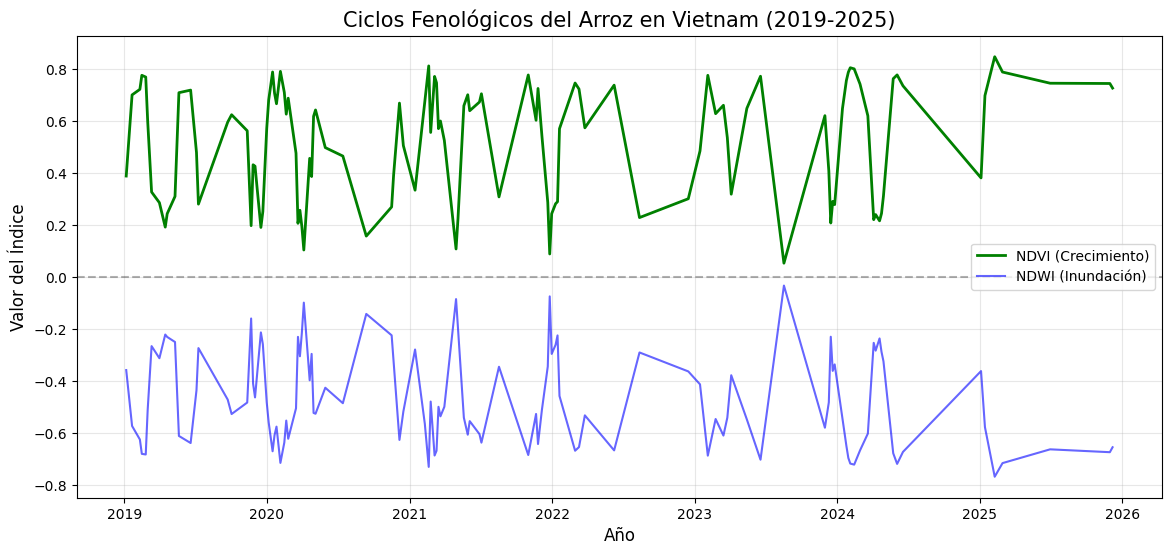

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Agrupar por fecha para ver el promedio de todos los puntos (la señal limpia)
df_resumen = df.groupby('fecha').mean().reset_index()

# 2. Configurar el gráfico
plt.figure(figsize=(14, 6))

# Dibujar NDVI (Verdor)
sns.lineplot(data=df_resumen, x='fecha', y='NDVI', label='NDVI (Crecimiento)', color='green', linewidth=2)

# Dibujar NDWI (Agua)
sns.lineplot(data=df_resumen, x='fecha', y='NDWI', label='NDWI (Inundación)', color='blue', alpha=0.6)

# 3. Estética del gráfico
plt.title('Ciclos Fenológicos del Arroz en Vietnam (2019-2025)', fontsize=15)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Valor del Índice', fontsize=12)
plt.axhline(0, color='black', linestyle='--', alpha=0.3) # Línea base
plt.legend()
plt.grid(alpha=0.3)

plt.show()

# PREPROCESAMIENTO Y LIMPIEZA

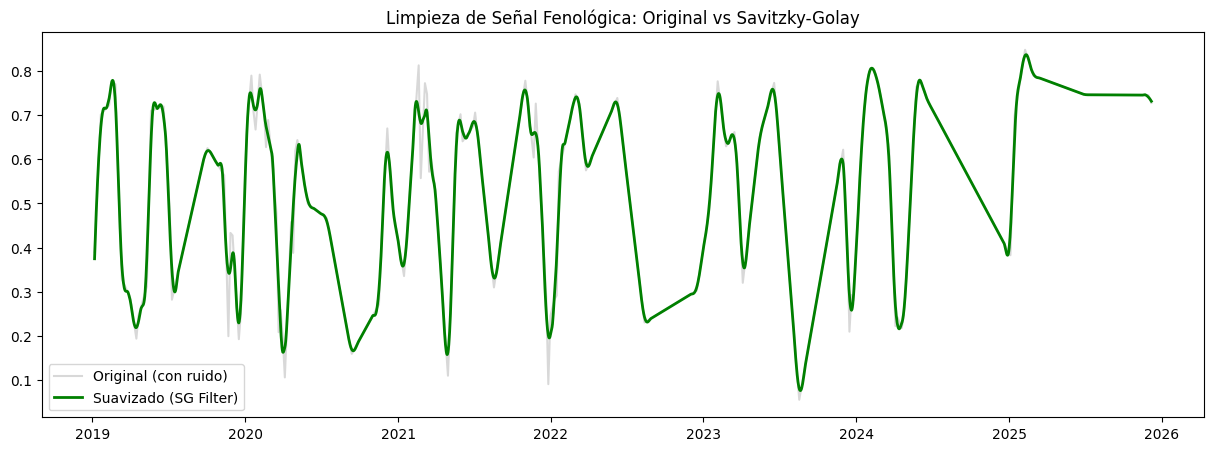

In [10]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

# 1. Cargar y preparar
df = pd.read_csv('Dataset_Arroz_Vietnam_BigData_2017_2025.csv').sort_values('fecha')
df['fecha'] = pd.to_datetime(df['fecha'])

# 2. Remuestreo (Resampling) 
# Los satélites pasan en días irregulares. Vamos a crear una serie diaria interpolada
# para que el filtro de señales funcione correctamente.
df_diario = df.set_index('fecha').resample('D').mean().interpolate(method='linear')

# 3. Aplicar Filtro Savitzky-Golay (Smoothing)
# window_length: debe ser impar. polyorder: orden del polinomio.
df_diario['NDVI_smooth'] = savgol_filter(df_diario['NDVI'], window_length=31, polyorder=2)
df_diario['NDWI_smooth'] = savgol_filter(df_diario['NDWI'], window_length=31, polyorder=2)

# 4. Graficar el cambio
plt.figure(figsize=(15, 5))
plt.plot(df_diario.index, df_diario['NDVI'], label='Original (con ruido)', alpha=0.3, color='gray')
plt.plot(df_diario.index, df_diario['NDVI_smooth'], label='Suavizado (SG Filter)', color='green', linewidth=2)
plt.title('Limpieza de Señal Fenológica: Original vs Savitzky-Golay')
plt.legend()
plt.show()

# ANALISIS ESTACIONAL

C:\Users\gutie\AppData\Local\Temp\ipykernel_23484\2026316194.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_diario, x='mes', y='NDVI_smooth', palette='viridis')


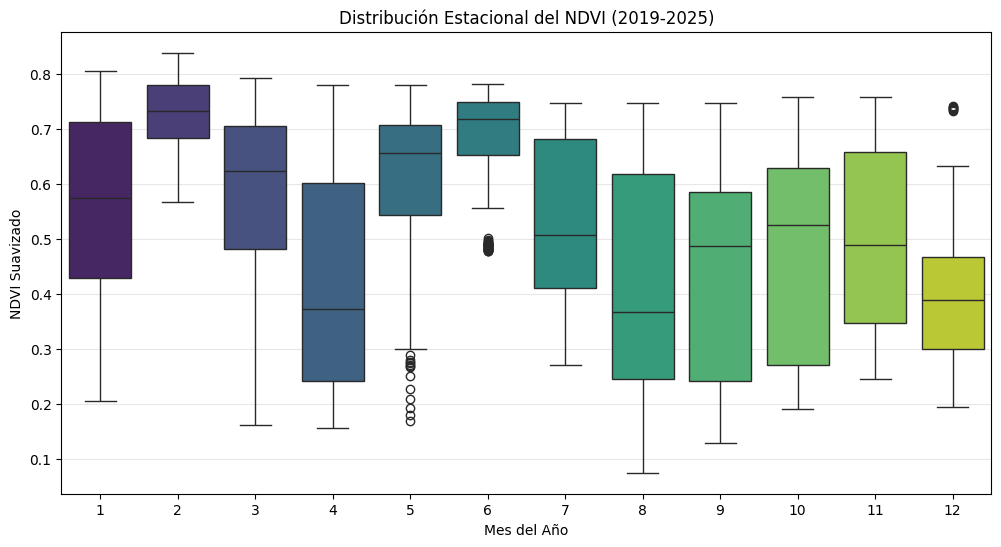

In [13]:
import seaborn as sns

# 1. Crear una columna de Mes y Año
df_diario['mes'] = df_diario.index.month
df_diario['año'] = df_diario.index.year

# 2. Graficar la distribución mensual del NDVI
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_diario, x='mes', y='NDVI_smooth', palette='viridis')
plt.title('Distribución Estacional del NDVI (2019-2025)')
plt.xlabel('Mes del Año')
plt.ylabel('NDVI Suavizado')
plt.grid(axis='y', alpha=0.3)
plt.show()

# CICLOS DE CULTIVO

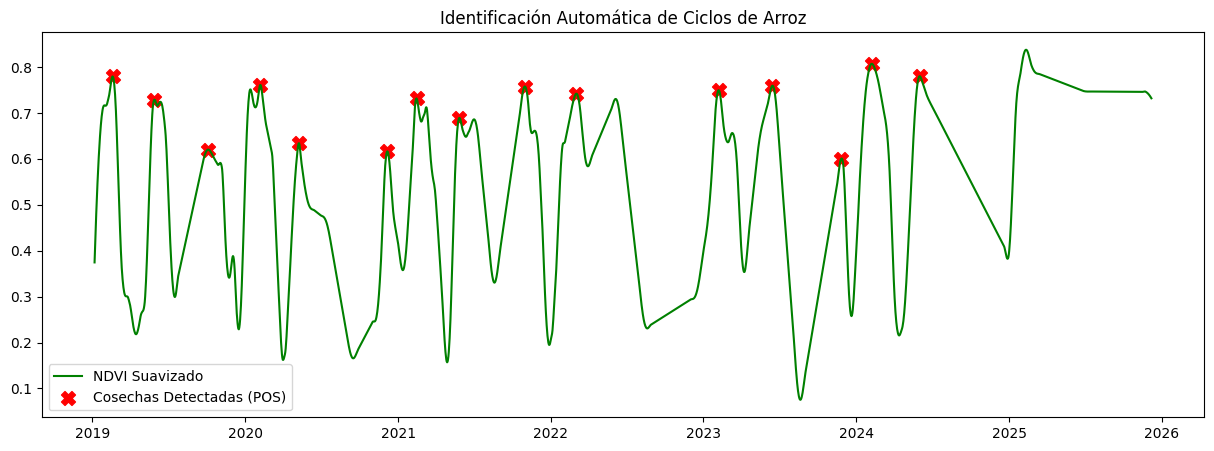

Se han detectado 15 ciclos de cultivo completos.


In [16]:
from scipy.signal import find_peaks

# 1. Detectar los picos (Cosechas máximas)
# Ajustamos 'distance' para que no detecte dos picos en la misma cosecha
# 'prominence' asegura que el pico sea significativo
indices_picos, _ = find_peaks(df_diario['NDVI_smooth'], distance=60, prominence=0.2)
picos_fechas = df_diario.index[indices_picos]

# 2. Graficar los picos detectados
plt.figure(figsize=(15, 5))
plt.plot(df_diario.index, df_diario['NDVI_smooth'], color='green', label='NDVI Suavizado')
plt.scatter(picos_fechas, df_diario.loc[picos_fechas, 'NDVI_smooth'], 
            color='red', marker='X', s=100, label='Cosechas Detectadas (POS)')
plt.title('Identificación Automática de Ciclos de Arroz')
plt.legend()
plt.show()

print(f"Se han detectado {len(picos_fechas)} ciclos de cultivo completos.")

# ETIQUETADO

In [19]:
# 1. Derivada del NDVI
df_diario['ndvi_velocity'] = df_diario['NDVI_smooth'].diff()

# 2. Inicializar target
df_diario['etapa'] = 'Otros'

# 3. Madurez (picos)
for pico in picos_fechas:
    mask = (
        (df_diario.index >= pico - pd.Timedelta(days=7)) &
        (df_diario.index <= pico + pd.Timedelta(days=7))
    )
    df_diario.loc[mask, 'etapa'] = 'Madurez'

# 4. Inundación
df_diario.loc[
    (df_diario['NDWI_smooth'] > -0.3) &
    (df_diario['NDVI_smooth'] < 0.3) &
    (df_diario['etapa'] == 'Otros'),
    'etapa'
] = 'Inundación'

# 5. Crecimiento
df_diario.loc[
    (df_diario['ndvi_velocity'] > 0.005) &
    (df_diario['etapa'] == 'Otros'),
    'etapa'
] = 'Crecimiento'

# 6. Cosecha
df_diario.loc[
    (df_diario['ndvi_velocity'] < -0.005) &
    (df_diario['etapa'] == 'Otros'),
    'etapa'
] = 'Cosecha'


In [21]:
# Crear la columna Target basada en reglas lógicas y picos detectados
df_diario['etapa'] = 'Otros'

# Regla 1: Madurez (ventana de 15 días alrededor de los picos detectados)
for pico in picos_fechas:
    mask = (df_diario.index >= pico - pd.Timedelta(days=7)) & (df_diario.index <= pico + pd.Timedelta(days=7))
    df_diario.loc[mask, 'etapa'] = 'Madurez'

# Regla 2: Inundación (NDWI alto y NDVI bajo)
df_diario.loc[(df_diario['NDWI_smooth'] > -0.3) & (df_diario['NDVI_smooth'] < 0.3), 'etapa'] = 'Inundación'

# Regla 3: Crecimiento (Diferencia positiva de NDVI)
df_diario.loc[(df_diario['ndvi_velocity'] > 0.005) & (df_diario['etapa'] == 'Otros'), 'etapa'] = 'Crecimiento'

# Regla 4: Cosecha (Diferencia negativa de NDVI)
df_diario.loc[(df_diario['ndvi_velocity'] < -0.005) & (df_diario['etapa'] == 'Otros'), 'etapa'] = 'Cosecha'

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Seleccionamos nuestras Features (lo que el modelo "ve")
features = ['NDVI_smooth', 'NDWI_smooth', 'ndvi_velocity', 'mes']
X = df_diario[features]
y = df_diario['etapa']

# Split de datos (80% entreno, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluación
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Cosecha       0.99      0.99      0.99        93
 Crecimiento       0.94      0.99      0.96        81
  Inundación       1.00      1.00      1.00        57
     Madurez       0.91      0.75      0.82        40
       Otros       0.98      1.00      0.99       235

    accuracy                           0.97       506
   macro avg       0.96      0.94      0.95       506
weighted avg       0.97      0.97      0.97       506



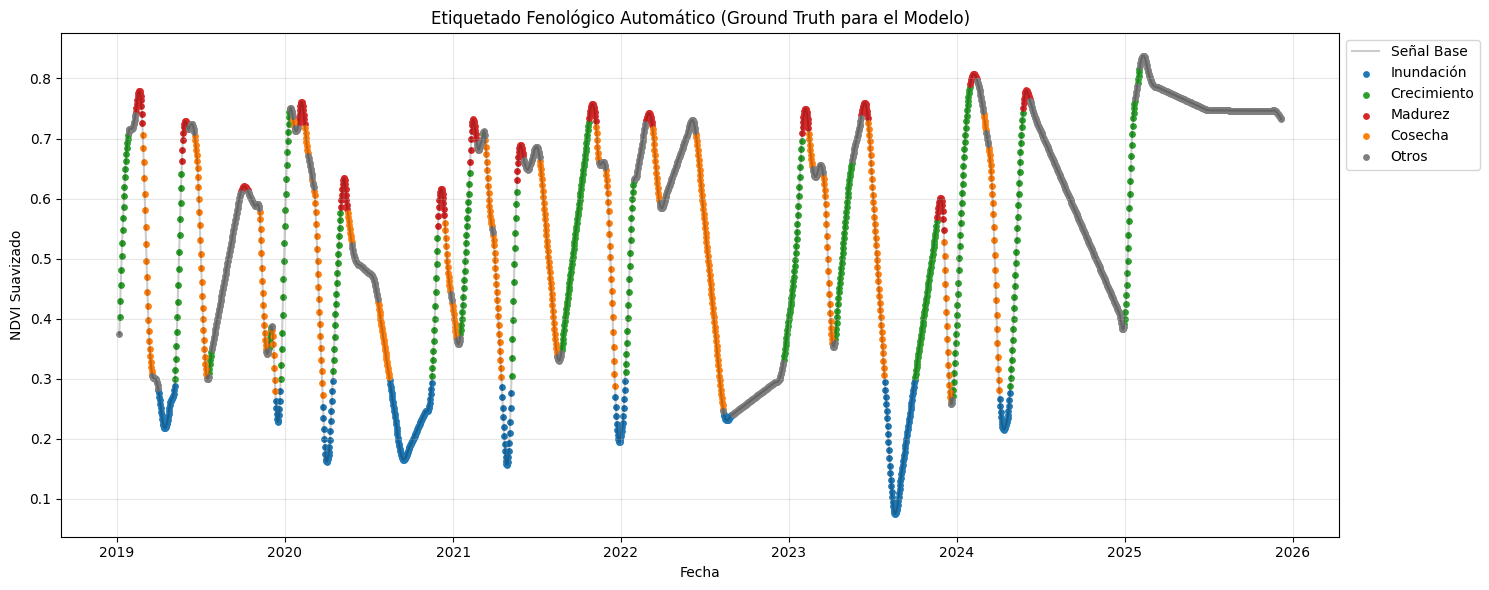

In [24]:
# 1. Configurar los colores para cada etapa
colores = {
    'Inundación': '#1f77b4', # Azul
    'Crecimiento': '#2ca02c', # Verde
    'Madurez': '#d62728',     # Rojo
    'Cosecha': '#ff7f0e',      # Naranja
    'Otros': '#7f7f7f'        # Gris
}

# 2. Graficar
plt.figure(figsize=(15, 6))

# Graficamos la línea base del NDVI
plt.plot(df_diario.index, df_diario['NDVI_smooth'], color='black', alpha=0.2, label='Señal Base')

# Pintar cada etapa con su color
for etapa, color in colores.items():
    mask = df_diario['etapa'] == etapa
    plt.scatter(df_diario.index[mask], df_diario.loc[mask, 'NDVI_smooth'], 
                color=color, label=etapa, s=15)

plt.title('Etiquetado Fenológico Automático (Ground Truth para el Modelo)')
plt.xlabel('Fecha')
plt.ylabel('NDVI Suavizado')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

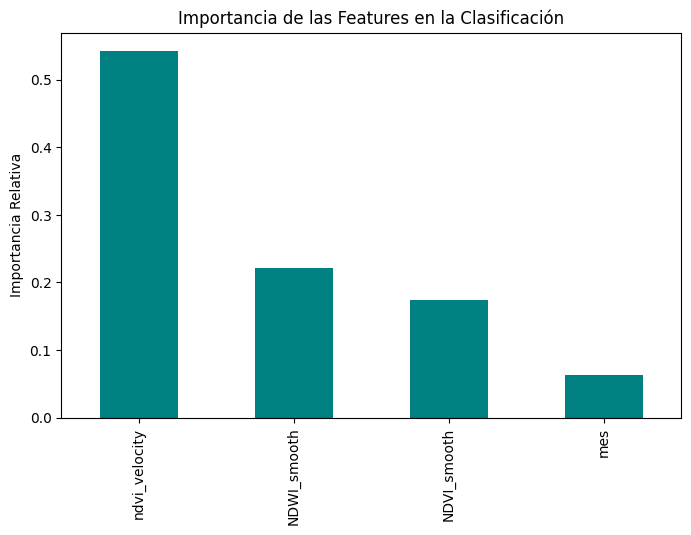

In [26]:
# Ver qué features son más importantes
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
importances.plot(kind='bar', color='teal')
plt.title('Importancia de las Features en la Clasificación')
plt.ylabel('Importancia Relativa')
plt.show()

<Figure size 1000x800 with 0 Axes>

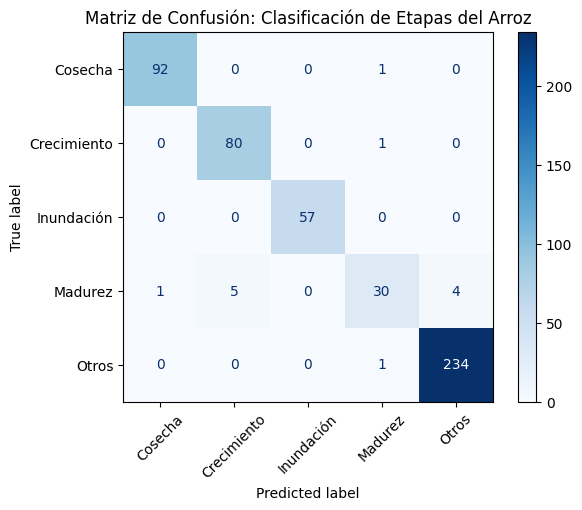

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay

# Graficar la Matriz de Confusión
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(
    model, X_test, y_test, 
    display_labels=model.classes_,
    cmap='Blues', 
    xticks_rotation=45
)
plt.title('Matriz de Confusión: Clasificación de Etapas del Arroz')
plt.show()

# ANALISIS DE SERIES TEMPORALES

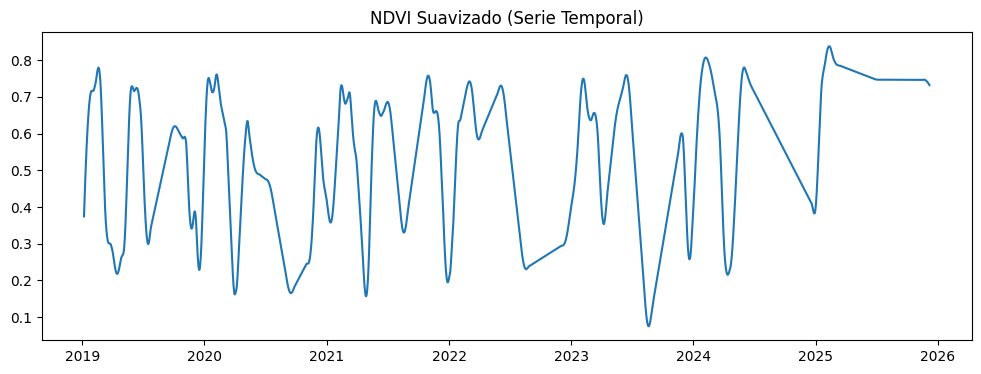

In [32]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Serie objetivo
serie = df_diario['NDVI_smooth'].dropna()

plt.figure(figsize=(12,4))
plt.plot(serie)
plt.title("NDVI Suavizado (Serie Temporal)")
plt.show()


In [34]:
resultado = adfuller(serie)
print(f"ADF statistic: {resultado[0]}")
print(f"p-value: {resultado[1]}")


ADF statistic: -3.65805925575327
p-value: 0.004743292645492297


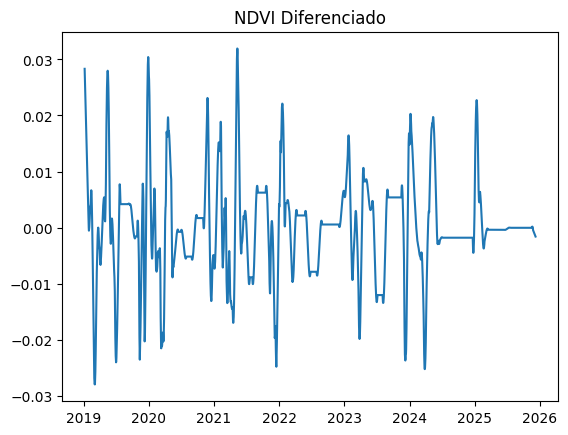

np.float64(1.3416940555287526e-16)

In [35]:
serie_diff = serie.diff().dropna()

plt.plot(serie_diff)
plt.title("NDVI Diferenciado")
plt.show()

adfuller(serie_diff)[1]


In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Opción 1: Sin componente estacional (si tus datos no son claramente estacionales)
modelo = SARIMAX(
    serie,
    order=(1, 1, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Opción 2: Estacionalidad semanal (más común y manejable)
modelo = SARIMAX(
    serie,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),  # s=7 para patrones semanales
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Opción 3: Estacionalidad mensual
modelo = SARIMAX(
    serie,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 30),  # s=30 para patrones mensuales
    enforce_stationarity=False,
    enforce_invertibility=False
)

resultado = modelo.fit(disp=False)  # disp=False oculta mensajes de convergencia
print(resultado.summary())

C:\Users\gutie\IA\ANALITICA DE DATOS\lstm_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                        NDVI_smooth   No. Observations:                 2528
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 30)   Log Likelihood               13908.133
Date:                            Mon, 19 Jan 2026   AIC                         -27806.267
Time:                                    19:38:23   BIC                         -27777.217
Sample:                                01-06-2019   HQIC                        -27795.713
                                     - 12-07-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9921      0.002    489.752      0.000       0.988       0.996
ma.L1          1.1339      0.005   

C:\Users\gutie\IA\ANALITICA DE DATOS\lstm_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2)x(1, 1, 1, 30): AIC=-23942.28, Ljung-Box p=0.0000
(2, 1, 1)x(1, 1, 1, 30): AIC=-30784.75, Ljung-Box p=0.0001


C:\Users\gutie\IA\ANALITICA DE DATOS\lstm_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1)x(1, 1, 2, 30): AIC=-26327.45, Ljung-Box p=0.0000


C:\Users\gutie\IA\ANALITICA DE DATOS\lstm_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1)x(2, 1, 1, 30): AIC=-27592.96, Ljung-Box p=0.0000


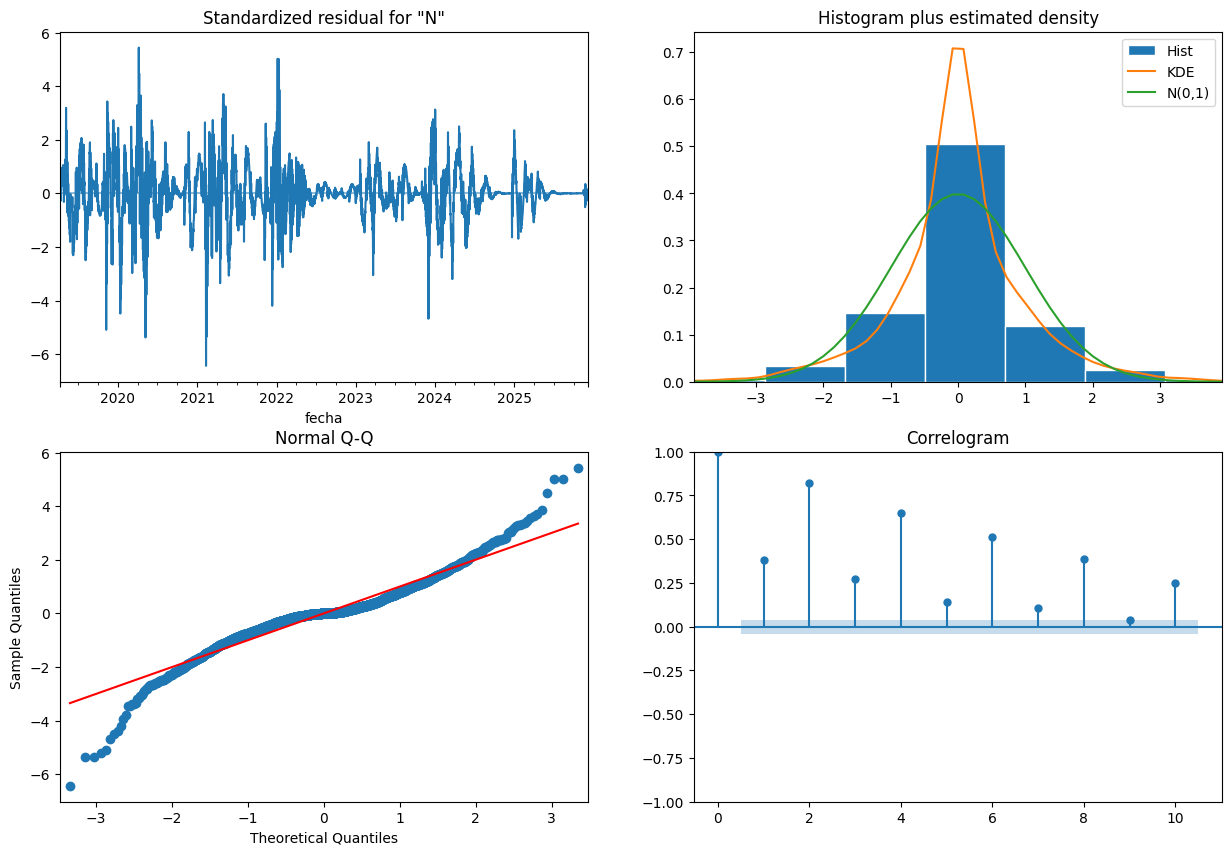

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# 1. Prueba diferentes órdenes
modelos_candidatos = [
    ((1, 1, 2), (1, 1, 1, 30)),  # Más términos MA
    ((2, 1, 1), (1, 1, 1, 30)),  # Más términos AR
    ((1, 1, 1), (1, 1, 2, 30)),  # Más términos MA estacionales
    ((1, 1, 1), (2, 1, 1, 30)),  # Más términos AR estacionales
]

mejores_resultados = []

for order, seasonal in modelos_candidatos:
    try:
        modelo = SARIMAX(
            serie,
            order=order,
            seasonal_order=seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        resultado = modelo.fit(disp=False, maxiter=200)
        
        mejores_resultados.append({
            'order': order,
            'seasonal': seasonal,
            'aic': resultado.aic,
            'bic': resultado.bic,
            'ljung_box_p': resultado.test_serial_correlation('ljungbox')[0, -1, 1]
        })
        
        print(f"{order}x{seasonal}: AIC={resultado.aic:.2f}, Ljung-Box p={mejores_resultados[-1]['ljung_box_p']:.4f}")
    except:
        continue

# 2. Diagnóstico visual de residuos
resultado.plot_diagnostics(figsize=(15, 10))
plt.show()


Ljung-Box a diferentes lags:
       lb_stat     lb_pvalue
10  167.641601  8.536009e-31
20  167.906015  2.212113e-25
30  422.025623  9.724671e-71

Outliers detectados: 7 (0.28%)


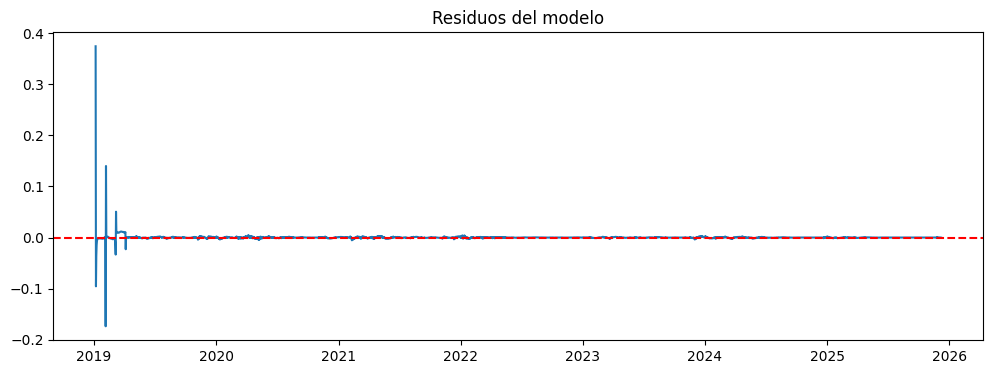

In [40]:
# Verifica los residuos
residuos = resultado.resid

# Test más exhaustivo de autocorrelación
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuos, lags=[10, 20, 30], return_df=True)
print("\nLjung-Box a diferentes lags:")
print(lb_test)

# Detecta outliers
import numpy as np
umbral = 3 * np.std(residuos)
outliers = np.abs(residuos) > umbral
print(f"\nOutliers detectados: {outliers.sum()} ({100*outliers.sum()/len(residuos):.2f}%)")

# Gráfico de residuos
plt.figure(figsize=(12, 4))
plt.plot(residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuos del modelo')
plt.show()

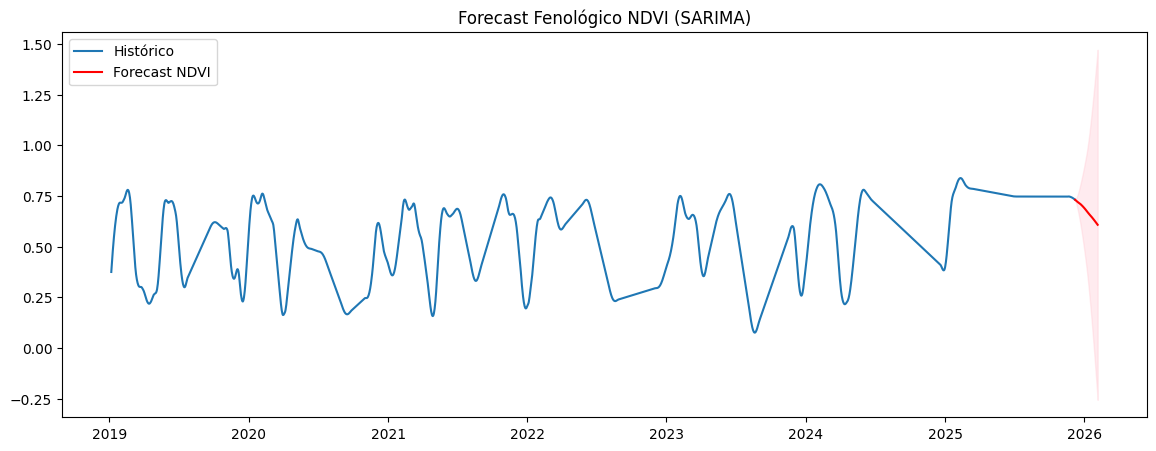

In [42]:
n_dias = 60

pred = resultado.get_forecast(steps=n_dias)
pred_ci = pred.conf_int()

fechas_futuras = pd.date_range(
    start=serie.index[-1] + pd.Timedelta(days=1),
    periods=n_dias,
    freq='D'
)

plt.figure(figsize=(14,5))
plt.plot(serie.index, serie, label='Histórico')
plt.plot(fechas_futuras, pred.predicted_mean, label='Forecast NDVI', color='red')
plt.fill_between(
    fechas_futuras,
    pred_ci.iloc[:,0],
    pred_ci.iloc[:,1],
    color='pink',
    alpha=0.3
)
plt.legend()
plt.title("Forecast Fenológico NDVI (SARIMA)")
plt.show()


In [44]:
pred_series = pred.predicted_mean
fecha_pico = pred_series.idxmax()
print("Próxima madurez estimada:", fecha_pico)


Próxima madurez estimada: 2025-12-08 00:00:00
